In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.figsize"] = (20, 5)

import random
random.seed(42)

import torch
import torch.nn.functional as F
torch.manual_seed(42)

from model import NGram

import sys
sys.path.insert(0, "..")
import nn
from preprocessing import get_data, load_split_data

%matplotlib inline

## Load Data


In [ ]:
block_size = 3
words, stoi, itos = get_data()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = load_split_data(words, stoi, block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Model


In [ ]:
vocab_size = 27
n_embd = 10
n_hidden = 100

m = NGram(block_size, vocab_size, n_embd, n_hidden)

m.layers

47024


[Embedding (27, 10),
 Linear (30, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 100),
 BatchNorm1d (100),
 Tanh (),
 Linear (100, 27),
 BatchNorm1d (27)]

## Train


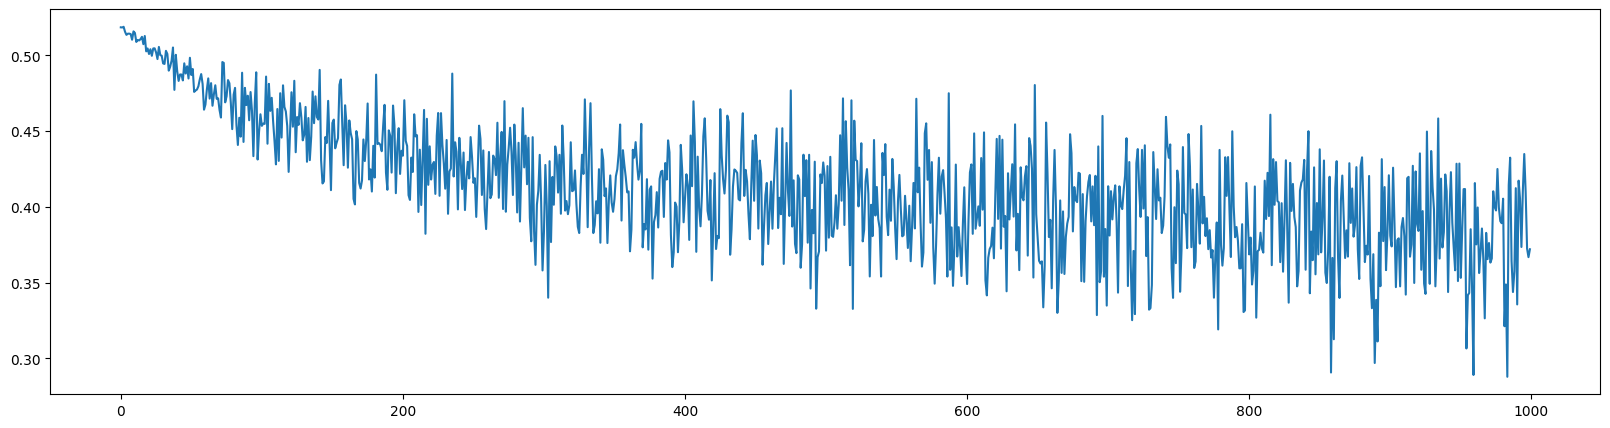

In [ ]:
max_steps = 1_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    logits = m(Xtr[ix])
    loss = F.cross_entropy(logits, Ytr[ix])

    for layer in m.layers:
        layer.out.retain_grad()
    for p in m.parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in m.parameters:
        p.data += -lr * p.grad

    # track stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in m.parameters]
        )

plt.plot(range(len(lossi)), lossi)

## Activation distribution


 3 Tanh () | mean -0.01 | std 0.64 | saturated: 2.28%
 6 Tanh () | mean -0.00 | std 0.65 | saturated: 1.97%
 9 Tanh () | mean -0.00 | std 0.65 | saturated: 2.16%
12 Tanh () | mean -0.00 | std 0.65 | saturated: 1.66%
15 Tanh () | mean +0.00 | std 0.65 | saturated: 1.47%


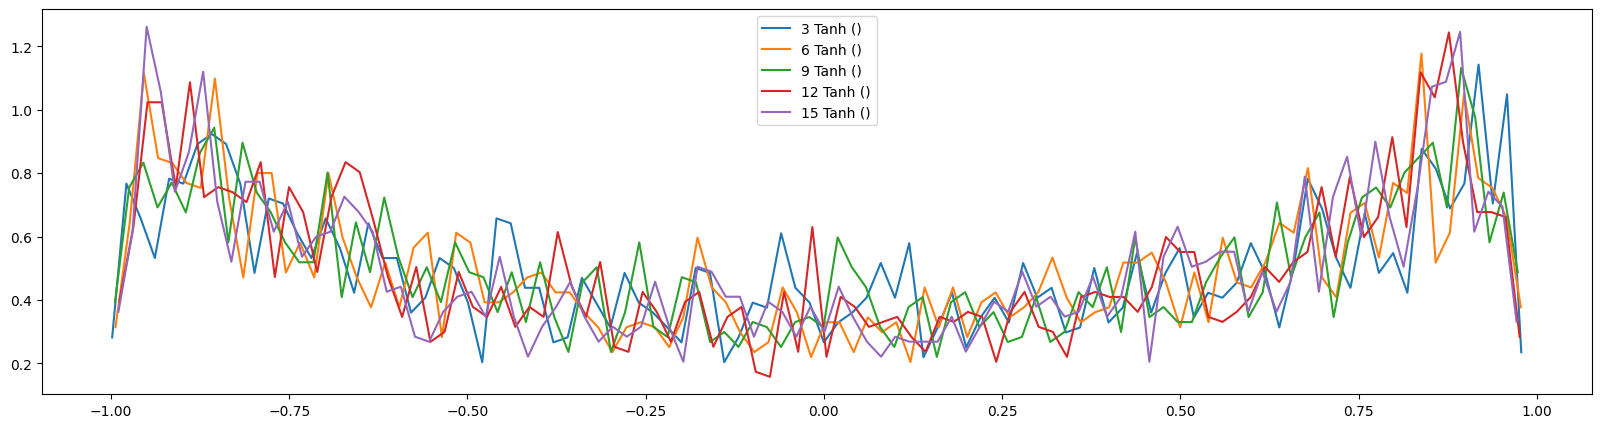

In [ ]:
legends = []
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Tanh):
        t = l.out.detach()
        print(
            "%2d %s | mean %+.2f | std %.2f | saturated: %.2f%%"
            % (
                i,
                l,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f"{i} {l}")
plt.legend(legends)

## Gradient distribution


 3 Tanh () | mean +0.00 | std +2.93e-03
 6 Tanh () | mean -0.00 | std +2.44e-03
 9 Tanh () | mean -0.00 | std +2.36e-03
12 Tanh () | mean +0.00 | std +2.30e-03
15 Tanh () | mean -0.00 | std +2.21e-03


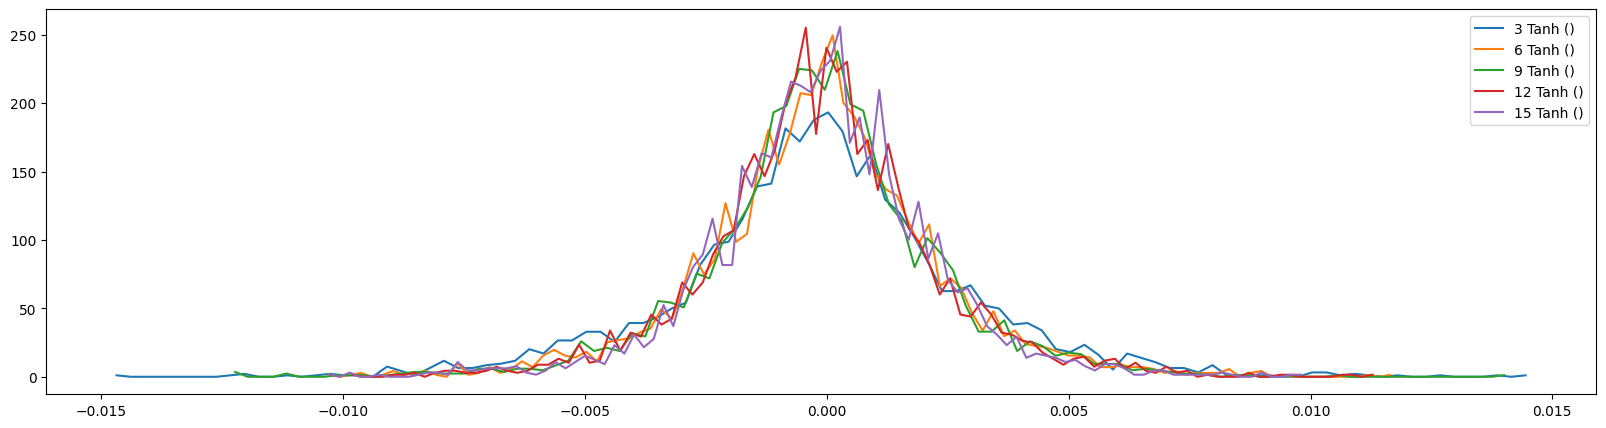

In [ ]:
legends = []
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Tanh):
        t = l.out.grad.detach()
        print("%2d %s | mean %+.2f | std %+.2e" % (i, l, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f"{i} {l}")
plt.legend(legends)

## Weights grad distribution


 0   Embedding (27, 10) | mean -0.00 | std 8.04e-03 | grad:data 8.03e-03
 1     Linear (30, 100) | mean -0.00 | std 1.07e-02 | grad:data 5.77e-02
 4    Linear (100, 100) | mean +0.00 | std 7.66e-03 | grad:data 7.52e-02
 7    Linear (100, 100) | mean -0.00 | std 7.26e-03 | grad:data 7.13e-02
10    Linear (100, 100) | mean -0.00 | std 6.86e-03 | grad:data 6.78e-02
13    Linear (100, 100) | mean -0.00 | std 6.86e-03 | grad:data 6.67e-02
16     Linear (100, 27) | mean -0.00 | std 1.47e-02 | grad:data 1.40e-01


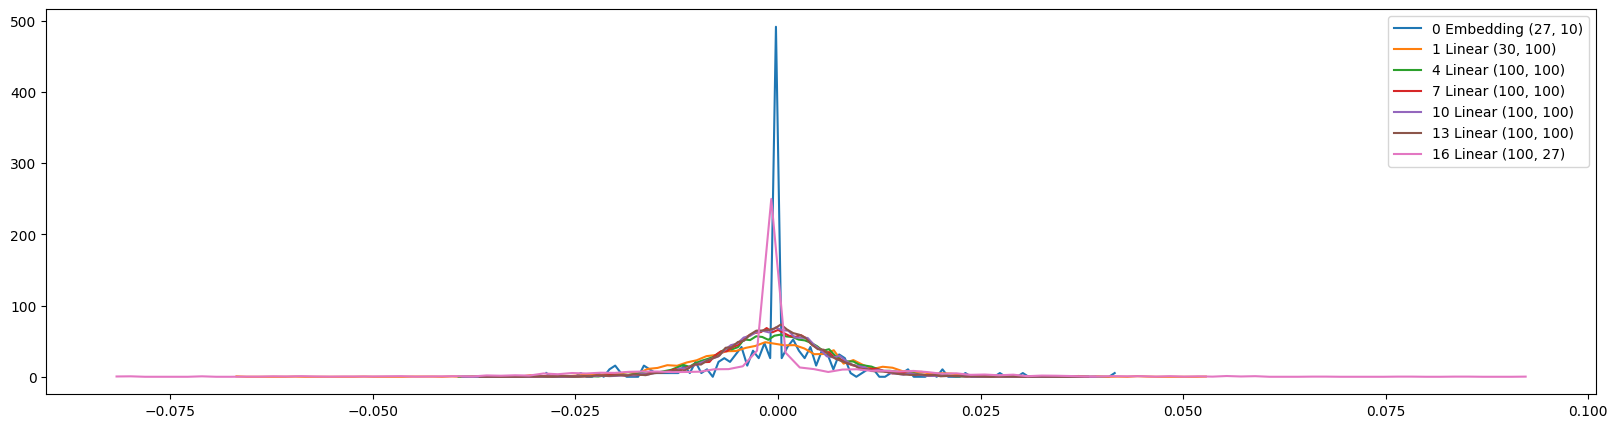

In [ ]:
legends = []
# for i, p in enumerate(m.parameters):
#     if p.ndim == 2:
#         t = p.grad.detach()
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Linear) or isinstance(l, nn.Embedding):
        p = l.weight.detach()
        t = l.weight.grad.detach()
        print(
            "%2d %20s | mean %+.2f | std %.2e | grad:data %.2e"
            % (i, l, t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f"{i} {l}")
plt.legend(legends)

## Lr \* grad


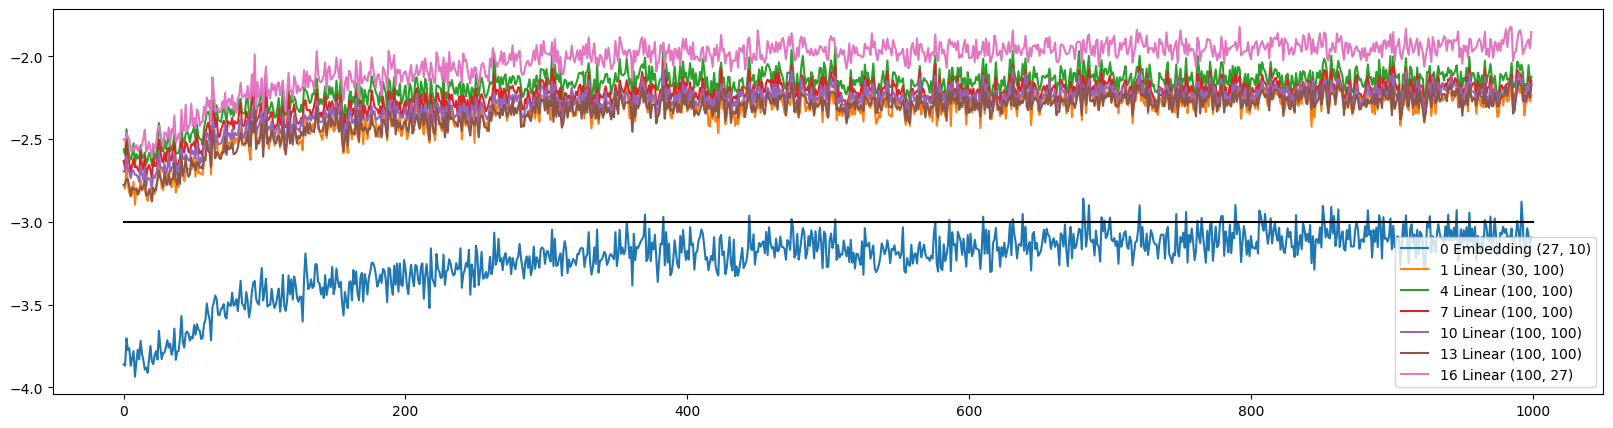

In [ ]:
legends = []
for i, l in enumerate(m.layers):
    if isinstance(l, nn.Linear) or isinstance(l, nn.Embedding):
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("%d %s" % (i, l))
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)